In [230]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

In [215]:
dataset = pd.read_excel('combined_hvp_numeric.xlsx')

In [216]:
Messages = dataset['Message']

In [217]:
Messages

0      I can morning. i'm Okay, how are you. that's a...
1      i'm doing good give me a. Second. yeah I can h...
2      morning. Barely good one are barely. that's al...
3      How are you. How. A lot a lot Oh, she got the ...
4      yeah I went to that page and I don't know what...
                             ...                        
653    Hello. Good how are you. Not much has happened...
654    There we go. i'm all right, I think I need to ...
655    Can you hear me. I know just confused I. yeah ...
656    Hello it's morning. You thought for sure I was...
657    around like the first week of September I star...
Name: Message, Length: 658, dtype: object

In [218]:
Traits = dataset.drop(columns=['Message','ID'])

In [219]:
Traits.head()

,AI% 1,AI% 2,BQa1,BQa2,BQr1,BQr2,CQ1,VQ Total +,VQ Total -,SQ Total +,...,DIM-I+ 1 Transposition,DIM-I+ 2 Transposition,DIM-I- 1 Transposition,DIM-I- 2 Transposition,DIM-S+ 1 Transposition,DIM-S+ 2 Transposition,DIM-S- 1 Transposition,DIM-S- 2 Transposition,Rho 1,Rho 2
0,0.500000,0.864583,151,90,6.9,13.9,1042,13,13,13,...,1,0,6,29,3,1,0,1,0.934,0.133
1,0.500000,0.583333,78,34,1.6,1.1,125,14,14,25,...,0,0,2,10,3,7,4,5,0.905,0.695
2,0.600000,0.702381,103,46,3.3,4.1,340,12,18,25,...,1,5,1,10,0,4,1,9,0.895,0.364
3,0.634615,0.500000,80,30,0.8,0.6,64,19,33,24,...,1,2,5,6,2,3,6,2,0.754,0.802
4,0.611111,0.500000,66,24,1.4,1.7,92,14,22,24,...,3,3,2,2,1,8,3,2,0.897,0.812


In [220]:
vectorizer = TfidfVectorizer(max_features=512)  # Use TF-IDF to convert text to embeddings
X = vectorizer.fit_transform(Messages)

In [225]:
X.shape

(658, 512)

In [223]:
y = Traits.values
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

In [361]:
def scale_back(scaler:MinMaxScaler,vector):
    return scaler.inverse_transform(vector.reshape(1,-1))

In [224]:
y.shape

(658, 112)

In [227]:
pca = PCA(n_components=20)
y_reduced = pca.fit_transform(y)

In [231]:
tuned_params = {
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 100
}
xgb_model = MultiOutputRegressor(XGBRegressor(**tuned_params))

In [233]:
pipeline = Pipeline([
    ('vectorizer', vectorizer),          # Step 1: Text vectorization
    ('regressor', xgb_model)             # Step 2 & 3: Multi-output regression
])

In [235]:
pipeline.fit(Messages, y_reduced)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=512)),
                ('regressor',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.8,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eta=0.1,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)))])

In [398]:
def predict_traits(id,input_text):
    y_pred_reduced = pipeline.predict([input_text])
    y_pred_full = pca.inverse_transform(y_pred_reduced)[0]
    y_pred_full = np.array([float(score) for score in y_pred_full])
    trait_names = list(Traits.columns) + ['ID','Message']
    trait_dict = dict(zip(trait_names, [round(float(trait),4) for trait in scale_back(scaler,y_pred_full)[0]] +[id,input_text] ))
    return trait_dict,scale_back(scaler,y_pred_full)

In [399]:
scores = []
output = []
for index,row in dataset.iterrows():
    input_text = row['Message']
    predicted_traits,y_out = predict_traits(row['ID'],input_text)
    score = r2_score(scale_back(scaler,y[index])[0],y_out[0])
    scores.append(score)
    output.append(predicted_traits)

In [400]:
pd.DataFrame(output).to_excel('NewOutputsScaled.xlsx',index=False)

In [383]:
from matplotlib import pyplot as plt
import seaborn as sns

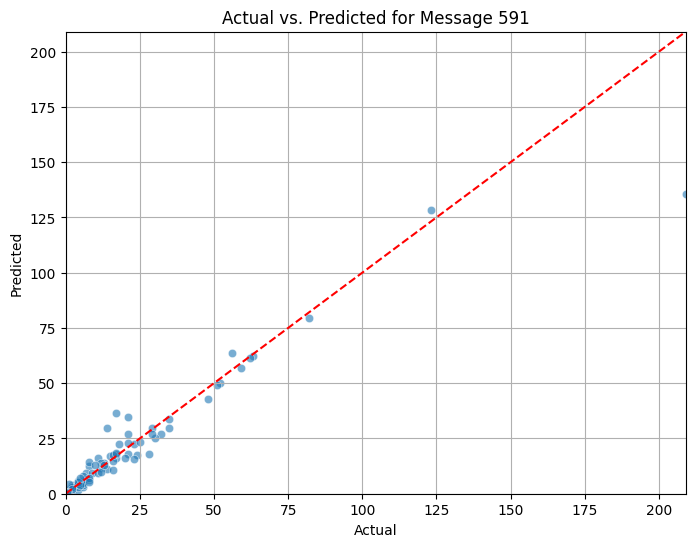

In [384]:
train_index = 2
input = Messages[trait_index]
predicted_traits,y_out = predict_traits(input)

df = pd.DataFrame({
    'Actual': scale_back(scaler,y[trait_index])[0],
    'Predicted': y_out[0]
})

# Create the scatter plot using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Actual', y='Predicted', alpha=0.6)

# Add a line for perfect prediction
max_value = max(df['Actual'].max(), df['Predicted'].max())
plt.plot([0, max_value], [0, max_value], 'r--')  # Line for perfect prediction

plt.title(f'Actual vs. Predicted for Message {trait_index + 1}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.grid(True)
plt.show()

In [401]:
import joblib
joblib.dump(pipeline, 'my_pipeline.pkl')


['my_pipeline.pkl']